<a href="https://colab.research.google.com/github/avk4714/DL_Projects/blob/master/Dropout_DNN_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementation of the Dropout Method to determine Cartpole dynamics**

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli
import matplotlib.pyplot as plt
import csv

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [0]:
class Net(nn.Module):
  def __init__(self, D_in1, n_hidden, D_out1, z_prob1, lam_mult1):
    super(Net, self).__init__()
    # Layers
    self.model_L_1 = torch.nn.Linear(D_in1, n_hidden, bias=True)
    self.model_D_1 = torch.nn.Dropout(p=z_prob1)
    self.model_L_2 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_2 = torch.nn.Dropout(p=z_prob1)
    self.model_L_3 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_3 = torch.nn.Dropout(p=z_prob1)
    self.model_L_4 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
    self.model_D_4 = torch.nn.Dropout(p=z_prob1)
    self.model_L_5 = torch.nn.Linear(n_hidden, D_out1, bias=True)

  def forward(self, x):
    pred_1 = self.model_D_1(F.relu(self.model_L_1(x)))
    pred_2 = self.model_D_2(F.relu(self.model_L_2(pred_1)))
    pred_3 = self.model_D_3(F.relu(self.model_L_3(pred_2)))
    pred_4 = self.model_D_4(F.relu(self.model_L_4(pred_3)))
    y_pred = self.model_L_5(pred_4)
    return y_pred

In [0]:
from numpy import genfromtxt

train_x = genfromtxt('train_x_data_2.csv', delimiter=',')
train_y = genfromtxt('train_y_data_2.csv', delimiter=',')
train_x_tnsr = torch.from_numpy(train_x)
train_y_tnsr = torch.from_numpy(train_y)
M = train_x_tnsr.shape[0]

**Calling DNN for Model Training**

In [5]:
'''Training Parameter Settings'''
n_samples = 500
n_hidden = 1000
z_prob = 0.2
lam_mult = 1e-2
d_in = 6            # Inputs are: [p, dp, dtheta, sin(theta), cos(theta), action]
d_out = 4           # Outputs are: [ddtheta, ddp, dtheta, dp]
runs = 20000

'''PyTorch Model Invocation'''
model = Net(d_in, n_hidden, d_out, z_prob, lam_mult).to(device)

'''Loss function and Optimizer'''
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=lam_mult)

'''Creating additional set of input features to feed in'''
# train_x_tnsr = torch.from_numpy(np.hstack((train_x_tnsr, train_x_tnsr[:,0].reshape(M,1)**2, train_x_tnsr[:,3].reshape(M,1)**2, train_x_tnsr[:,4].reshape(M,1)**2, train_x_tnsr[:,0].reshape(M,1)*train_x_tnsr[:,5].reshape(M,1), train_x_tnsr[:,1].reshape(M,1)*train_x_tnsr[:,5].reshape(M,1), train_x_tnsr[:,3].reshape(M,1)*train_x_tnsr[:,4].reshape(M,1))))
train_x_tnsr = train_x_tnsr.to(device)
train_y_tnsr = train_y_tnsr.to(device)
'''Training runs'''
loss_data = []
for t in range(runs):
  pred_y_tnsr = model(train_x_tnsr.float())
  loss = criterion(pred_y_tnsr.float(), train_y_tnsr.float())
  if t % 100 == 99:
    loss_data.append([t, loss.item()])
    print(t, loss.item())
  
  # zero gradients, perform a backward pass and update the weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


99 1479.97802734375
199 794.2193603515625
299 581.955322265625
399 530.30078125
499 426.48394775390625
599 387.91046142578125
699 352.41064453125
799 332.06158447265625
899 304.6856689453125
999 286.0869140625
1099 264.7396240234375
1199 277.091796875
1299 238.7506561279297
1399 228.19500732421875
1499 221.7922821044922
1599 208.2611846923828
1699 196.37359619140625
1799 200.62222290039062
1899 185.8295440673828
1999 194.85760498046875
2099 184.55380249023438
2199 169.03550720214844
2299 164.8105926513672
2399 167.47088623046875
2499 152.90689086914062
2599 154.03399658203125
2699 153.18167114257812
2799 142.3856201171875
2899 142.392578125
2999 140.5718536376953
3099 134.9086456298828
3199 129.43214416503906
3299 124.89431762695312
3399 121.3045654296875
3499 125.43624114990234
3599 121.07705688476562
3699 118.93045043945312
3799 122.0743637084961
3899 111.65147399902344
3999 116.98271179199219
4099 118.26451110839844
4199 106.19258880615234
4299 104.8907470703125
4399 102.60177612304

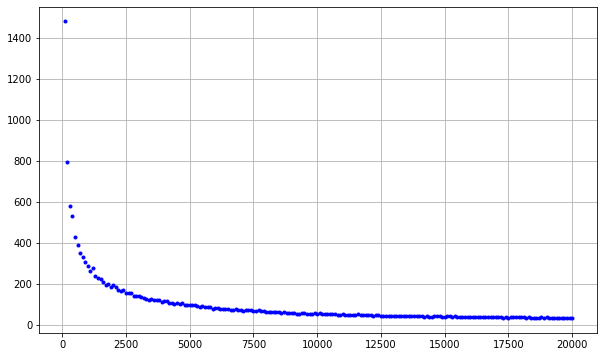

In [6]:
plt.figure(figsize=(10,6)) 
for t,l in loss_data:
  plt.plot(t,l,"b.")
plt.grid()
plt.show()

In [0]:
with open ('train_loss_5.csv', mode='w') as loss_dat:
  loss_write = csv.writer(loss_dat, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for t1,l1 in loss_data:
    loss_write.writerow([t1,l1])

In [0]:
PATH = './cartploe_ReLU.pth'
torch.save(model.state_dict(), PATH)